In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt


In [13]:
# Подгрузим данные
images = np.load('./data/images.npy')
labels = np.load('./data/labels.npy')
test_images = np.load("./data/images_sub.npy")

# Посмотрим на их форму
print(f"Images_shape {images.shape}")

print(f"Labels_shape {labels.shape}")
print(f"Labels {np.unique(labels)}")

print(f"Test_shape {test_images.shape}")

Images_shape (20000, 48, 48, 3)
Labels_shape (20000,)
Labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Test_shape (50000, 48, 48, 3)


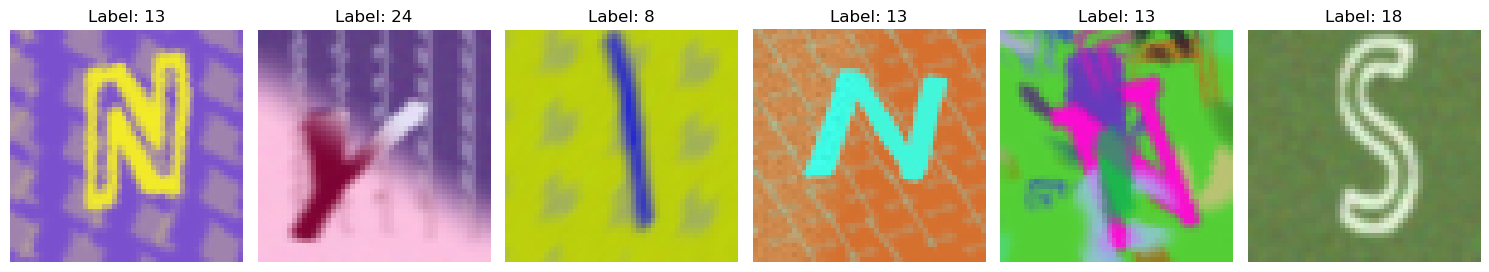

In [14]:
# Выберем первые 6 изображений
num_images = 6
sample_images = images[:num_images]
sample_labels = labels[:num_images]

# Визуализация
plt.figure(figsize=(15, 5))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

> Видим собственно форму, для последующих манипуляций приведем к тензорам данные массивы и немного передвинем оси, так как нам нужно поставить каналы на второе место после размера мега-батча и прийти к форме:

`(batch_size, chanel, high, width)`

In [15]:
# Переводим все в тензоры
images_tensor = torch.tensor(images, dtype=torch.float32)
# Нормализуем тензор
images_tensor = images_tensor / 255 - 0.5

labels_tensor = torch.tensor(labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)

test_images_tensor = test_images_tensor / 255 - 0.5

# А у тренировочного (потом еще валидационные вытащим) набора поменяем местами оси каналов и размера
images_tensor = images_tensor.permute(0, 3, 1, 2)
test_images_tensor = test_images_tensor.permute(0, 3, 1, 2)

In [16]:
# Объединим метки и изображение в один датасет
dataset_base = TensorDataset(images_tensor, labels_tensor)

# Разобьем на тренировочную и валидационную выборки в пропокция 0ю85, 0.15
train_size = int(0.9 * images_tensor.shape[0])
val_size = images_tensor.shape[0] - train_size

train, val = random_split(
    dataset= dataset_base, 
    lengths=[
        train_size,
        val_size
        ]
    )

train_dl = DataLoader(train, shuffle=True, batch_size=64)
val_dl = DataLoader(val, batch_size=64)

In [ ]:
# Класс модеои
class ImageClassifier(nn.Module):
    def __init__(self, num_chanels=3, num_classes=26):
        super().__init__()
        # Запихнем все преобразования в nn.Sequential
        self.features = nn.Sequential(
            nn.Conv2d(num_chanels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(), # решил поэксперементировать с фун-ей активации 
            nn.MaxPool2d(2), # макспуллинг для борьбы с переобучением
            nn.Dropout(0.2), # дропаут слои для борьбы с переобучением
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
            
        )
        
        # Так же поступим с полносвязным слоем и классификатором применим глобалпуллинг
        self.classificator = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256 ,num_classes) # то что пришло с последней свертки
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classificator(x)
        return x

In [18]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = 'cpu'

In [ ]:
# Проверим устройство
device

'mps'

In [ ]:
# Инициализируем модель, оптимизатор и функцию потерь
model = ImageClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.15)

# Инициируем шедуллер
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=3)

In [21]:
def train(model, num_epochs, train_dl, valid_dl, optimizer, loss_fn, device=device):
    # Перенесем модель на гпу
    model = model.to(device)
    
    loss_hist_train = [0] * num_epochs
    loss_hist_val = [0] * num_epochs
    
    acc_hist_train = [0] * num_epochs
    acc_hist_val = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            
            # перенесем тензоры на доступный гпу
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Шаг оптимизатора и обратный проход
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            
            # Добавляем лосс для построения гистограммы
            loss_hist_train[epoch] += loss.item() * y_batch.size(0) # накопление общего лосса
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_hist_train[epoch] += is_correct.sum()
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        acc_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                
                loss_hist_val[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                acc_hist_val[epoch] += is_correct.sum()
            
            loss_hist_val[epoch] /= len(valid_dl.dataset)
            acc_hist_val[epoch] /= len(valid_dl.dataset)
        
        scheduler.step(loss_hist_val[epoch])
        print(f"Эпоха: {epoch} \
            Точность на тренировочных данных - {acc_hist_train[epoch]}\
            Точность на валидации - {acc_hist_val[epoch]}")
        
    return loss_hist_train, loss_hist_val, acc_hist_train, acc_hist_val

In [22]:
torch.manual_seed(42)
num_epochs = 100

# Начнем обучение
loss_hist_train, loss_hist_val, acc_hist_train, acc_hist_val = train(
    model=model,
    num_epochs=num_epochs,
    train_dl=train_dl,
    valid_dl=val_dl,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

Эпоха: 0             Точность на тренировочных данных - 0.05161111056804657            Точность на валидации - 0.05999999865889549
Эпоха: 1             Точность на тренировочных данных - 0.07988888770341873            Точность на валидации - 0.0794999971985817
Эпоха: 2             Точность на тренировочных данных - 0.11944444477558136            Точность на валидации - 0.1274999976158142
Эпоха: 3             Точность на тренировочных данных - 0.16338889300823212            Точность на валидации - 0.18299999833106995
Эпоха: 4             Точность на тренировочных данных - 0.21061110496520996            Точность на валидации - 0.24250000715255737
Эпоха: 5             Точность на тренировочных данных - 0.269777774810791            Точность на валидации - 0.2590000033378601
Эпоха: 6             Точность на тренировочных данных - 0.32411110401153564            Точность на валидации - 0.3244999945163727
Эпоха: 7             Точность на тренировочных данных - 0.3813333213329315            Точ

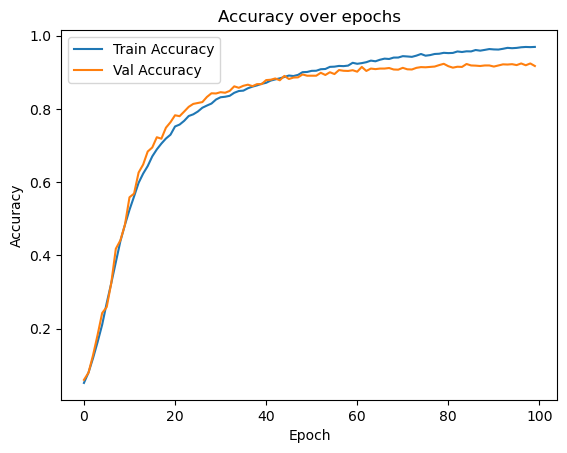

In [45]:
# Построим кривые тренировки и валидации
acc_hist_train_cpu = [i.cpu().numpy() for i in acc_hist_train]
acc_hist_val_cpu = [i.cpu().numpy() for i in acc_hist_val]

plt.plot(acc_hist_train_cpu, label='Train Accuracy')
plt.plot(acc_hist_val_cpu, label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Сохранение модели, что бы не обучать постоянно
torch.save(model.state_dict(), './image_classifier_2.pth')

# Загрузка
model = ImageClassifier(num_chanels=3, num_classes=26)
model.load_state_dict(torch.load('./image_classifier_2.pth'))
model.to(device)
model.eval()

ImageClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): GELU(approximate='none')
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): GELU(approximate='none')
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.2, inp

In [32]:
test_dataset = TensorDataset(test_images_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

all_predictions = []

# Сделаем прогноз для submission
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)

        outputs = model(x_batch)
        _, predicted = torch.max(outputs, dim=1)

        all_predictions.extend(predicted.cpu().numpy())

In [35]:
# Сохраним файл в нужном формате
df = pd.DataFrame({
    'Id': range(len(all_predictions)),
    'Category': all_predictions
})

df.to_csv('./data/submission.csv', index=False)